In [1]:
import sys
sys.path.append('..')

#### Using the data given 'An Alternative Propulsion Plant for Naval Auxiliary Ships' by Edward Lawrence Stone. (post-graduate thesis) 
![Auxiliary Ship Model](../T-AO-system_diagrams.png)

First read in the reliability data

In [2]:
import pandas as pd
import openpyxl

data= pd.read_excel("AuxilaryPropulsionPlant_Reliability_Availability_Data.xlsx")
print(data)

# defining the systems as they are shown in the image above
transmission_sys = [2, 3, 4]
engine_sys = [8, 9, 10, 11, 12, 6, 0, 1]
#fuel_sys = [(5, 6), 7] *2
# twin_engine_sys = [fuel_sys , (engine_sys_1, engine_sys_2), transmission_sys]


                Component    MTBF MTTR      R      A
0           Diesel Engine    8000    8  0.999  0.999
1                  Clutch   50000   NR  0.986  1.000
2          Reduction Gear  200000   NR  0.996  1.000
3      Shaft and Bearings  200000   NR  0.996  1.000
4          CRP Propellers   25000   15  0.999  0.999
5          Fuel Oil Motor    7500   18  0.998  0.997
6           Fuel Oil Pump    5500  4.5  0.999  0.999
7       Fuel Oil Purifier   10000    4  1.000  0.999
8          Lube Oil Motor    7500  7.8  0.999  0.998
9           Lube Oil Pump    4000    5  0.999  0.998
10      Jacket Water Pump   27000  7.6  0.999  0.999
11       Fresh Water Pump   12500   12  0.999  0.999
12  Fuel Oil Booster Pump    5500  4.5  0.999  0.999


# Transmission System Simulation
(Non-Repairable system)

[2, 3, 4]


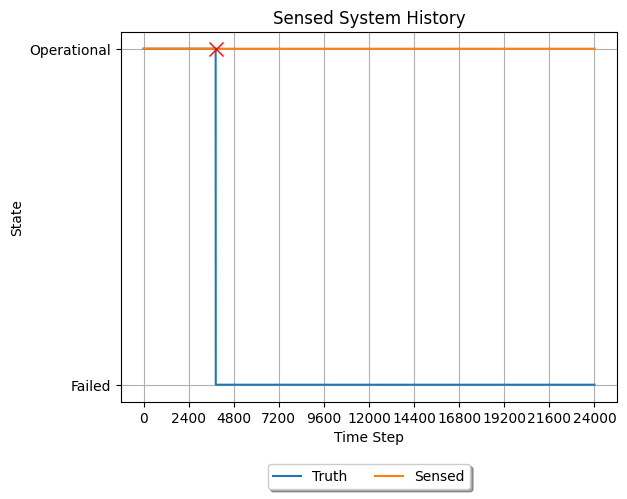

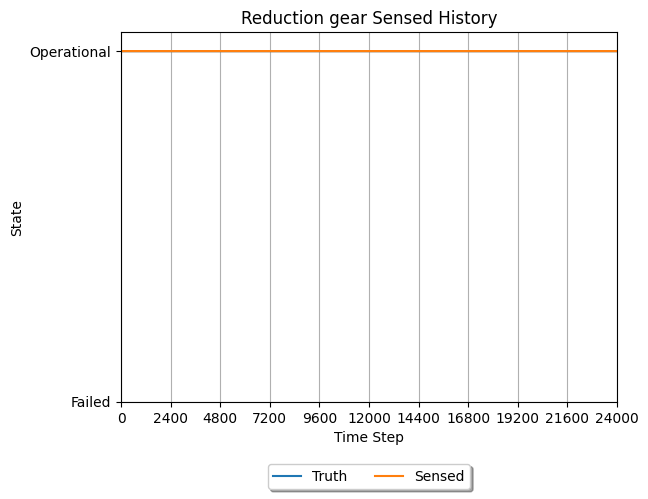

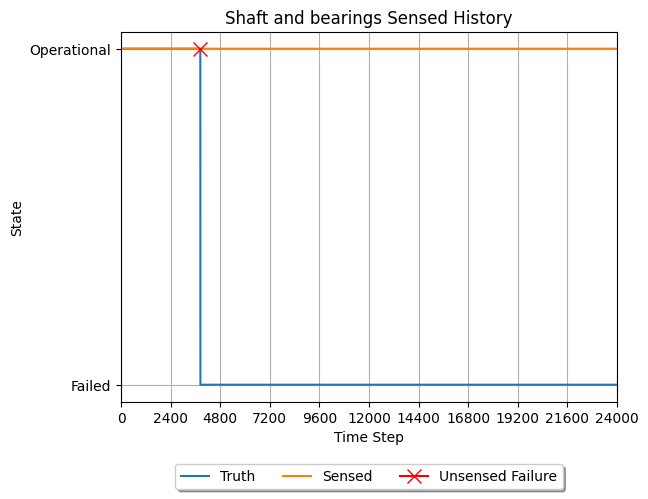

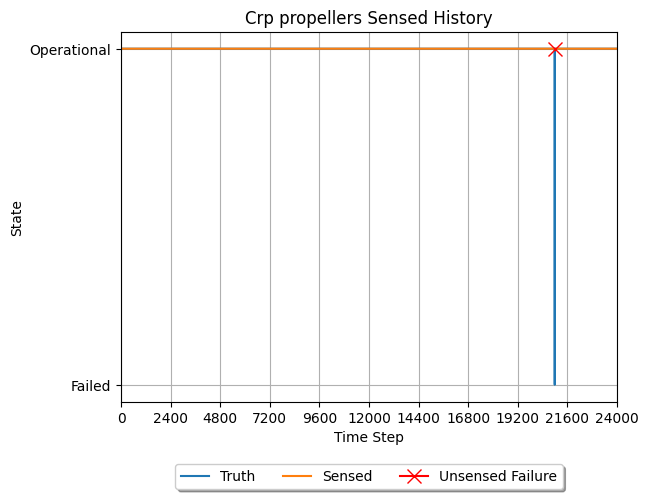

In [3]:
from shipClass.Component import Component
from shipClass.SensedComp import SensedComp
from shipClass.System import System

# list of the indices of equipment in the transmission system
print(transmission_sys)

# Create a Component object for each component in the transmission system
transmission_sys_comps = {}
states = {0: "Failed", 1: "Operational"}
for comp in transmission_sys:
    comp_name= data.Component[comp]
    non_sensed_comp = Component(comp_name, states, data.MTBF[comp], data.MTTR[comp])

    # make the components into sensed components
    transmission_sys_comps[comp_name] = SensedComp(non_sensed_comp)
    
transmission_sys_obj = System("Transmission System", list(transmission_sys_comps.values()) )
print(transmission_sys_obj)
# simulate the transmission system
sim_time = 24 * 1000# 24 hours * 1000 days
transmission_sys_obj.simulate(sim_time)
transmission_sys_obj.plotHistory(True)
transmission_sys_obj.printHistory2Excel("testResults/transmission_sys_results.xlsx")

# Diesel Engine System Simulation
(Repairable System)

[8, 9, 10, 11, 12, 6, 0, 1]


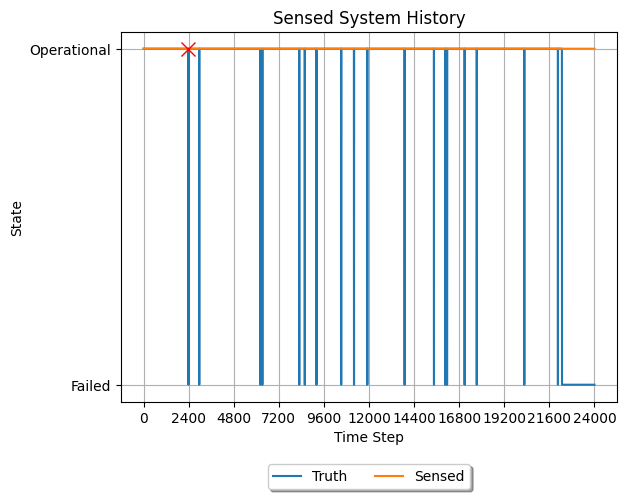

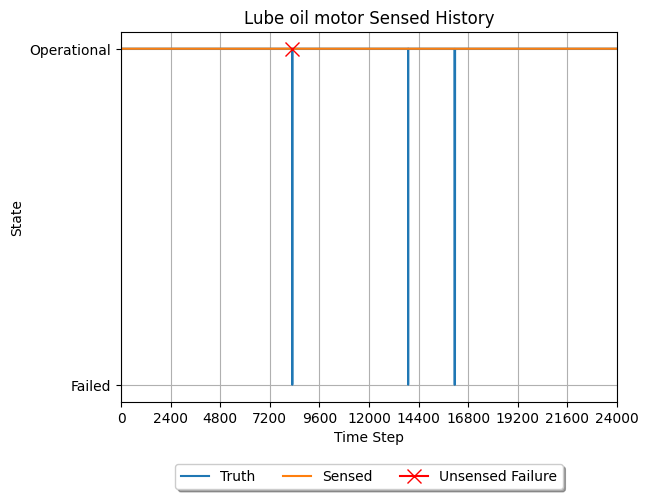

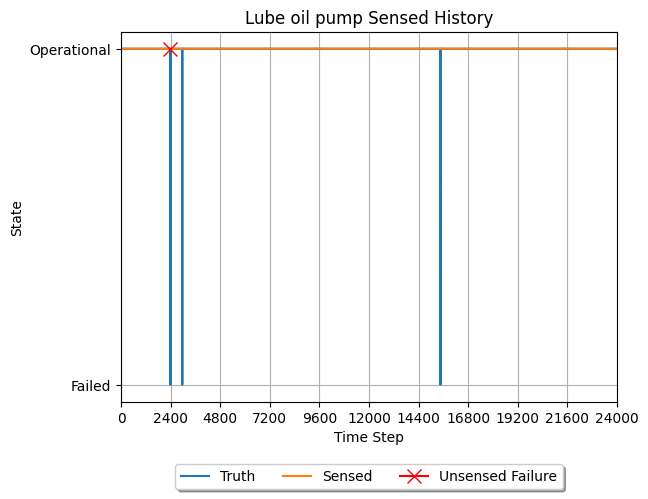

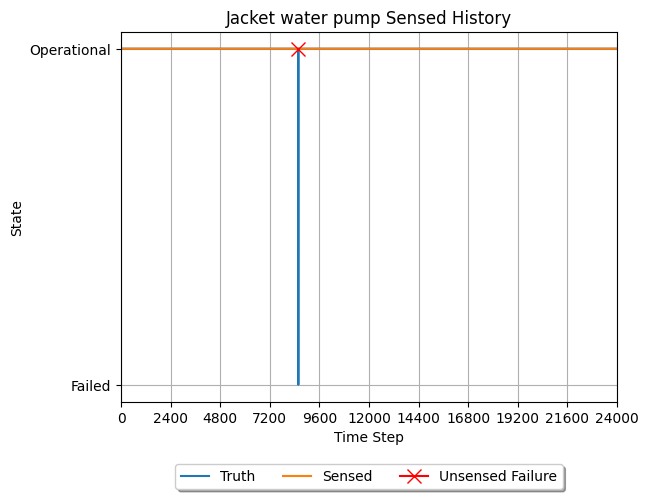

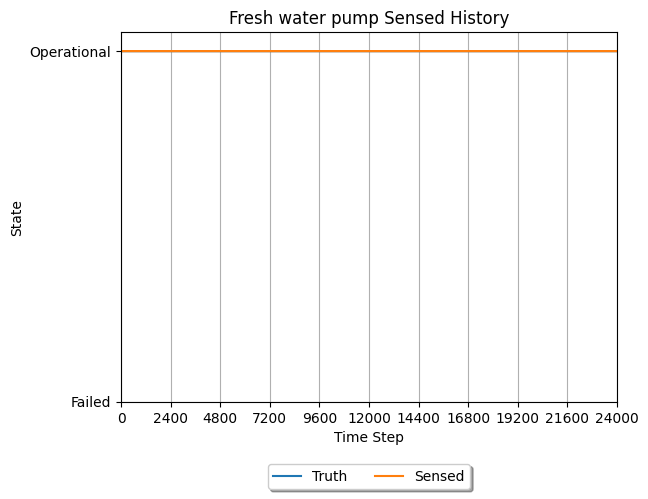

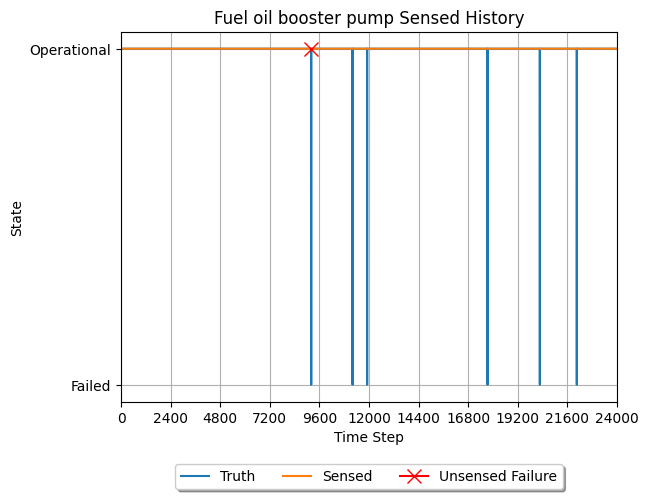

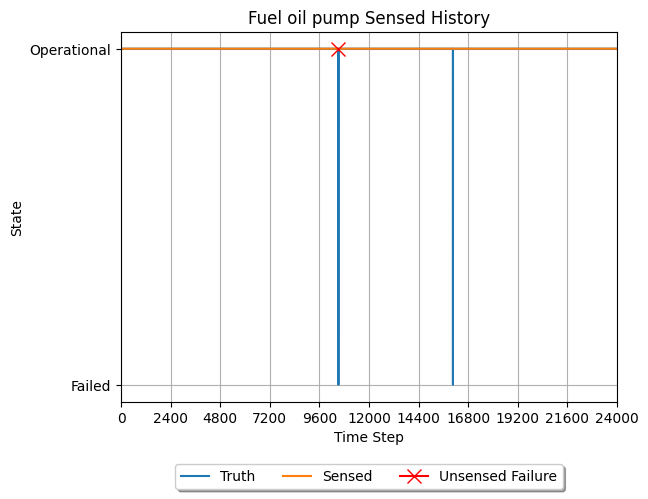

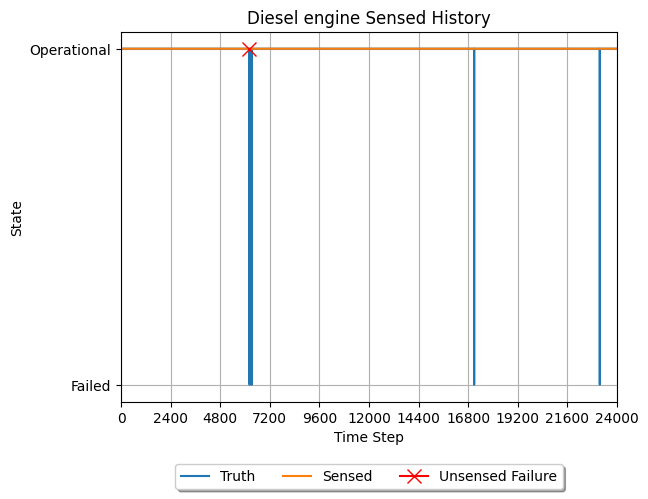

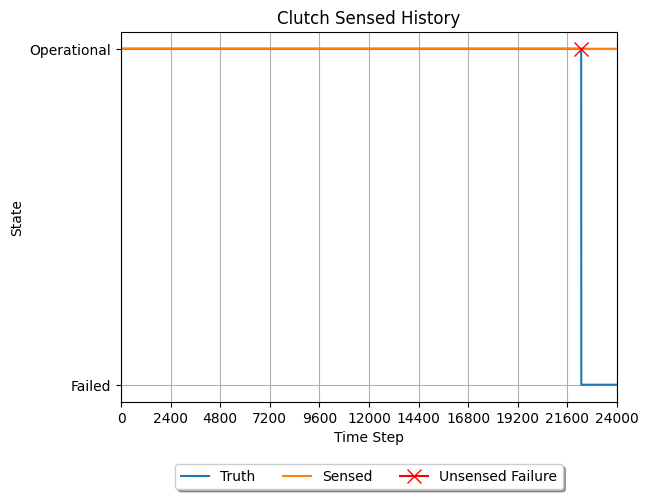

In [4]:
from shipClass.Component import Component
from shipClass.SensedComp import SensedComp
from shipClass.System import System

# list of the indices of equipment in the diesel engine system
print(engine_sys)

# Create a Component object for each component in the diesel engine system
engine_sys_comps = {}
states = {0: "Failed", 1: "Operational"}
for comp in engine_sys:
    comp_name= data.Component[comp]
    non_sensed_comp = Component(comp_name, states, data.MTBF[comp], data.MTTR[comp])

    # make the components into sensed components
    engine_sys_comps[comp_name] = SensedComp(non_sensed_comp)
    
engine_system_obj = System("Diesel Engine System", list(engine_sys_comps.values()) )
print(engine_system_obj)
# simulate the diesel engine system
sim_time = 24 * 1000# 24 hours * 1000 days
engine_system_obj.simulate(sim_time)
engine_system_obj.plotHistory(True)

Next, store the failure and repair rates for each piece of equipment in additional columns

In [4]:
# adding failure rates to column 3
failure_rates = [1/MTBF for MTBF in data.MTBF]
data.insert(2, 'Failure Rates', failure_rates)

# add failure rates to column 5 considerign repairable and non-repairable components (MTTR = 'NR') 
repair_rates = [None] * len(data.MTTR)
for i, MTTR in enumerate(data.MTTR): 
    if type(MTTR) is str:
        repair_rates[i] = 'NR'
    else: 
        repair_rates[i] = 1/MTTR
data.insert(4, 'Repair Rates', repair_rates)

print(data)

                Component    MTBF  Failure Rates MTTR Repair Rates      R  \
0           Diesel Engine    8000       0.000125    8        0.125  0.999   
1                  Clutch   50000       0.000020   NR           NR  0.986   
2          Reduction Gear  200000       0.000005   NR           NR  0.996   
3      Shaft and Bearings  200000       0.000005   NR           NR  0.996   
4          CRP Propellers   25000       0.000040   15     0.066667  0.999   
5          Fuel Oil Motor    7500       0.000133   18     0.055556  0.998   
6           Fuel Oil Pump    5500       0.000182  4.5     0.222222  0.999   
7       Fuel Oil Purifier   10000       0.000100    4         0.25  1.000   
8          Lube Oil Motor    7500       0.000133  7.8     0.128205  0.999   
9           Lube Oil Pump    4000       0.000250    5          0.2  0.999   
10      Jacket Water Pump   27000       0.000037  7.6     0.131579  0.999   
11       Fresh Water Pump   12500       0.000080   12     0.083333  0.999   

Next, setup a Markov Chain Transition Matrix for each component using their failure and repair rates

- Chain consists of two states (0: failed and 1: working) 
- transition matrix = [1-mu, mu; lambda, 1-lambda] where mu = repair rate and lambda= failure rate

In [5]:
import numpy as np

# create a dictionary to store each transition matrix
transition_matrices = {}

# loop through each component
indexed_data= data.set_index('Component')
for comp in data.Component:

    # grab the failure and repair rates
    fail_rate = indexed_data.loc[comp, 'Failure Rates']
    repair_rate = indexed_data.loc[comp, 'Repair Rates']
    if type(repair_rate) is str: repair_rate = 0    # i.e failure is an absorbing state

    # set the transition matrix up and store
    transition_matrix = np.array([[1-repair_rate, repair_rate], [fail_rate, 1-fail_rate]])
    transition_matrices[comp] = transition_matrix

# show that each component has its own transition matrix
print(transition_matrices)

{'Diesel Engine': array([[8.75000e-01, 1.25000e-01],
       [1.25000e-04, 9.99875e-01]]), 'Clutch': array([[1.0000e+00, 0.0000e+00],
       [2.0000e-05, 9.9998e-01]]), 'Reduction Gear': array([[1.00000e+00, 0.00000e+00],
       [5.00000e-06, 9.99995e-01]]), 'Shaft and Bearings': array([[1.00000e+00, 0.00000e+00],
       [5.00000e-06, 9.99995e-01]]), 'CRP Propellers': array([[9.33333333e-01, 6.66666667e-02],
       [4.00000000e-05, 9.99960000e-01]]), 'Fuel Oil Motor': array([[9.44444444e-01, 5.55555556e-02],
       [1.33333333e-04, 9.99866667e-01]]), 'Fuel Oil Pump': array([[7.77777778e-01, 2.22222222e-01],
       [1.81818182e-04, 9.99818182e-01]]), 'Fuel Oil Purifier': array([[7.500e-01, 2.500e-01],
       [1.000e-04, 9.999e-01]]), 'Lube Oil Motor': array([[8.71794872e-01, 1.28205128e-01],
       [1.33333333e-04, 9.99866667e-01]]), 'Lube Oil Pump': array([[8.0000e-01, 2.0000e-01],
       [2.5000e-04, 9.9975e-01]]), 'Jacket Water Pump': array([[8.68421053e-01, 1.31578947e-01],
       [3

Create and simulate each object as a Markov Chain

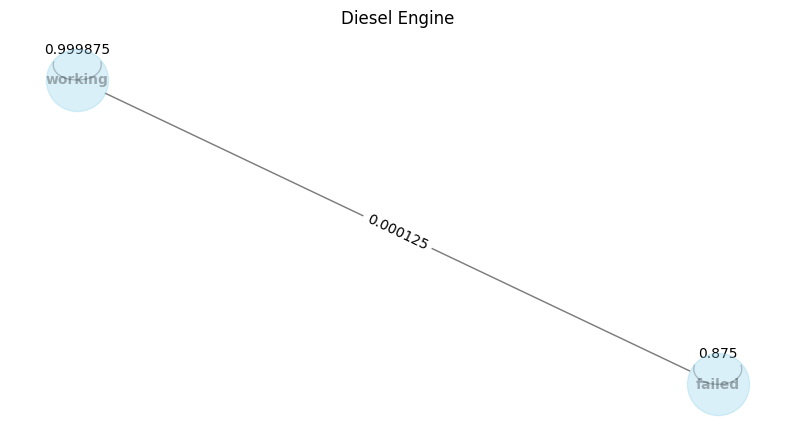

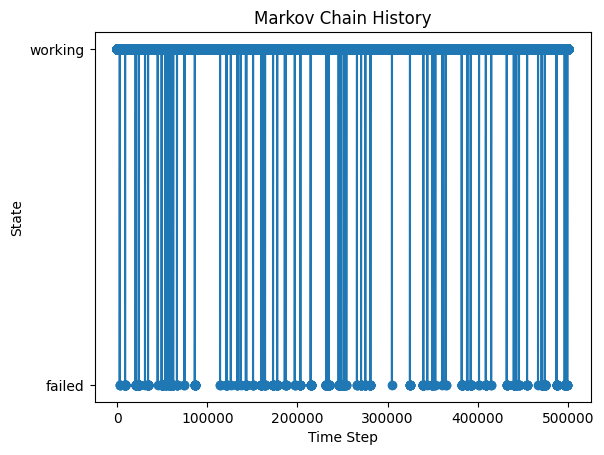

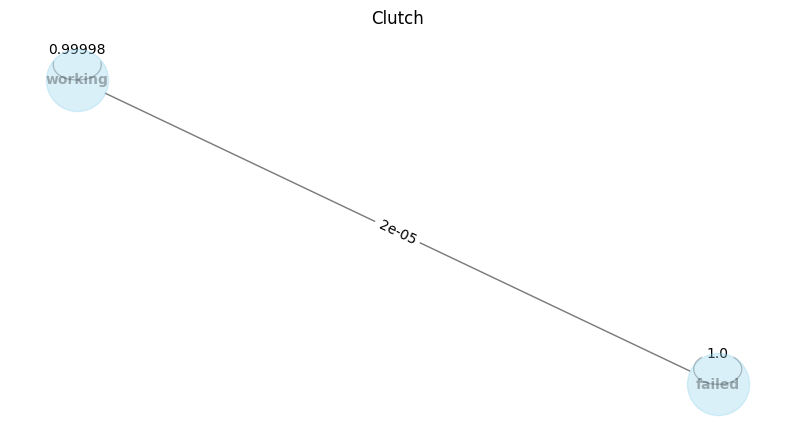

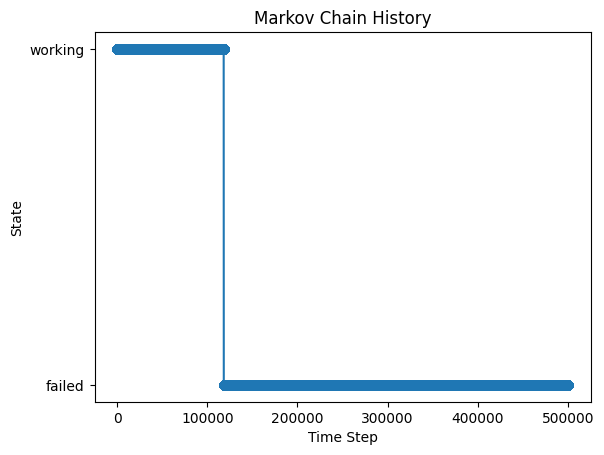

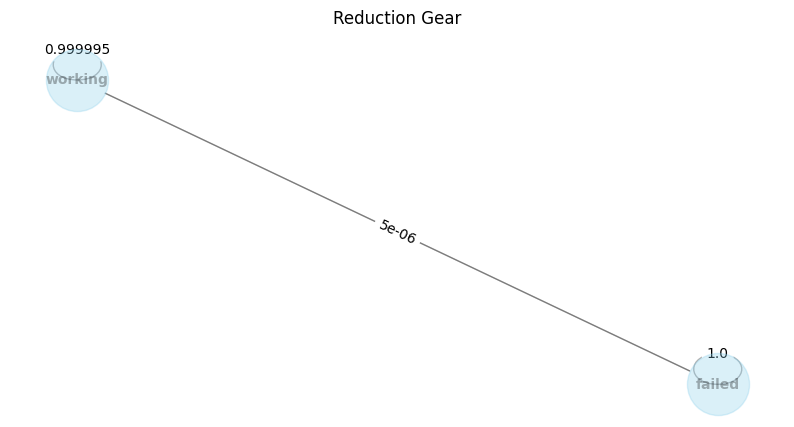

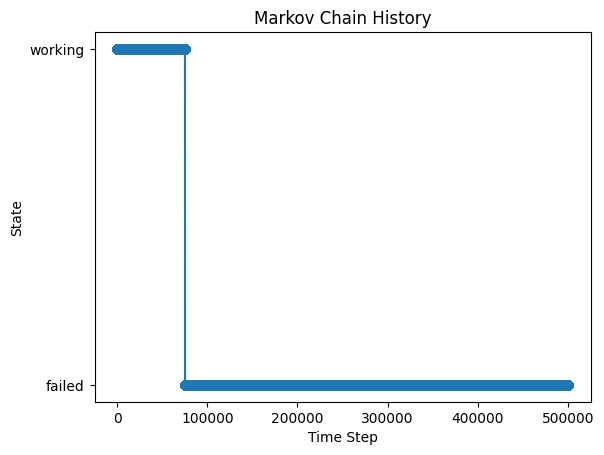

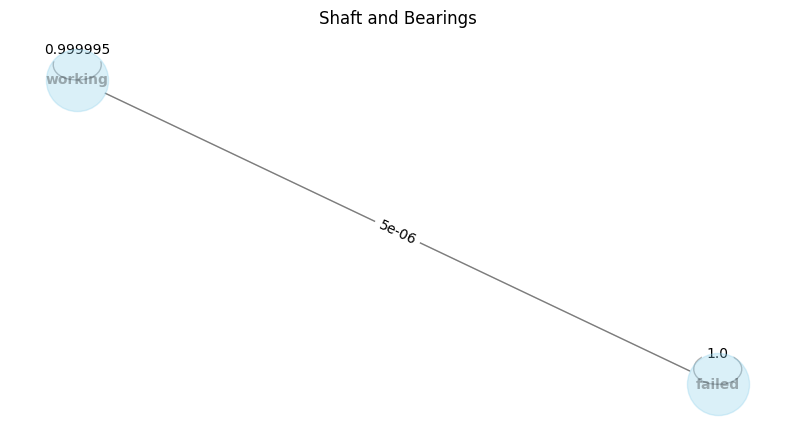

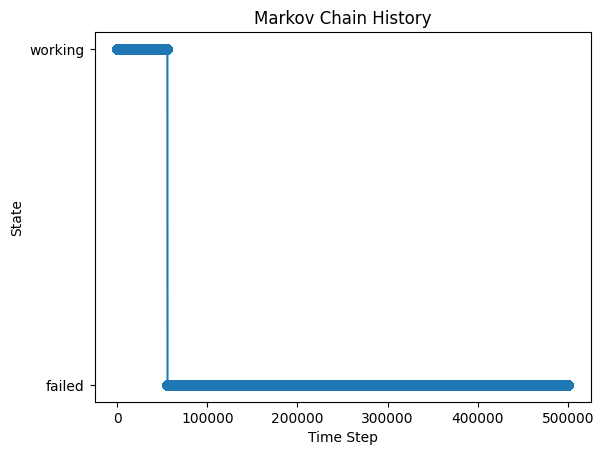

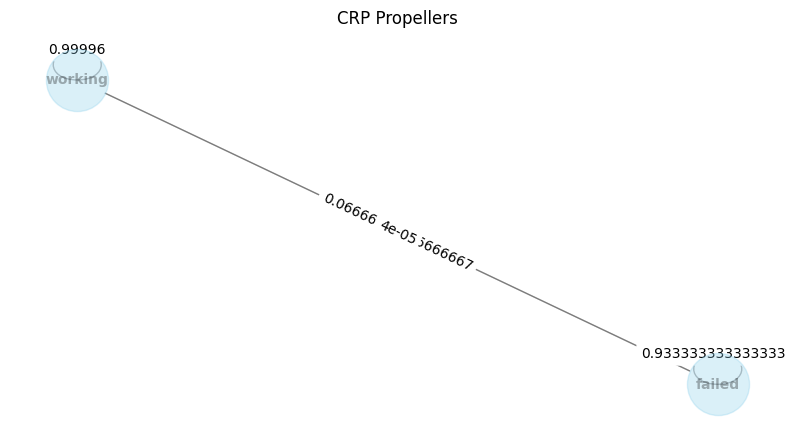

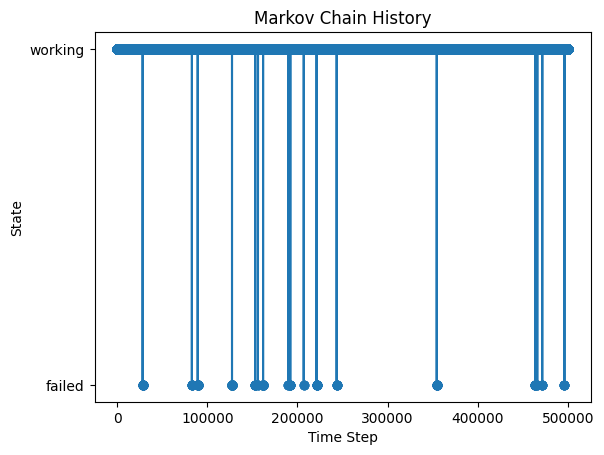

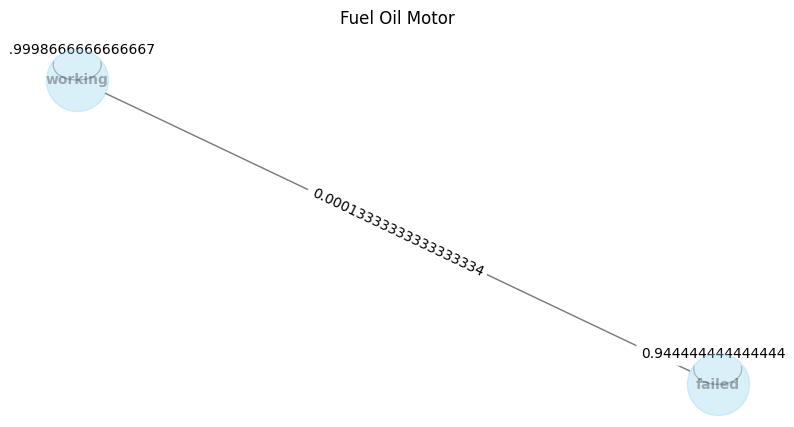

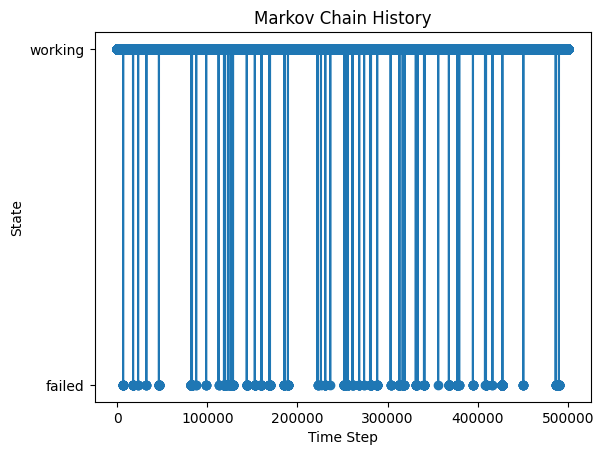

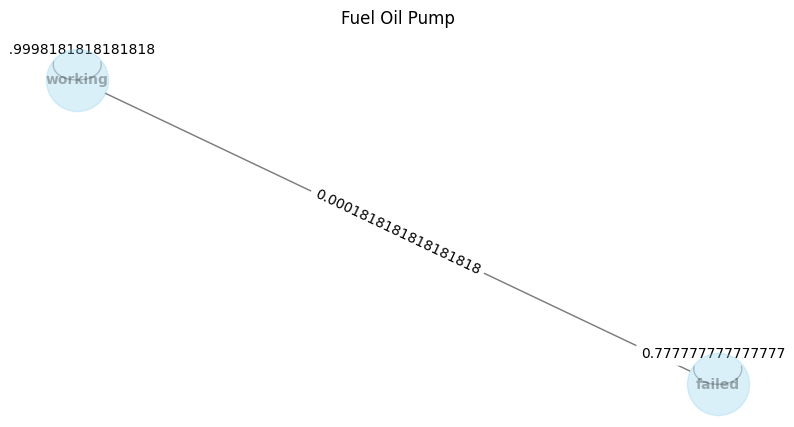

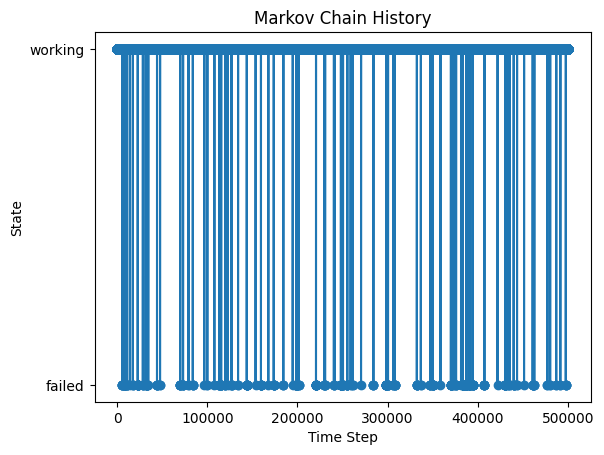

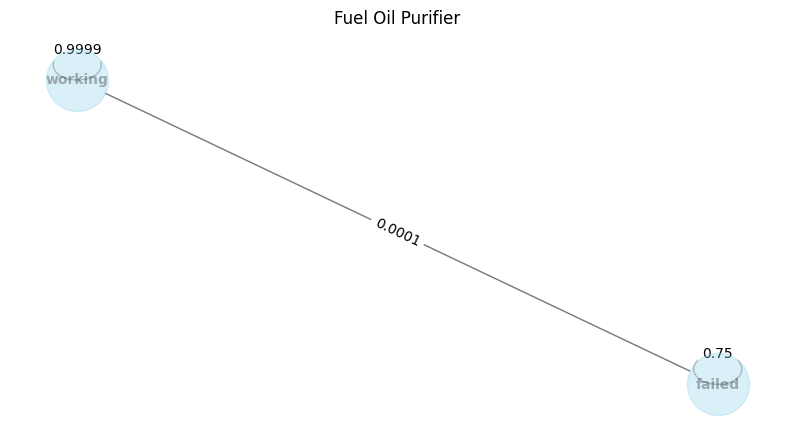

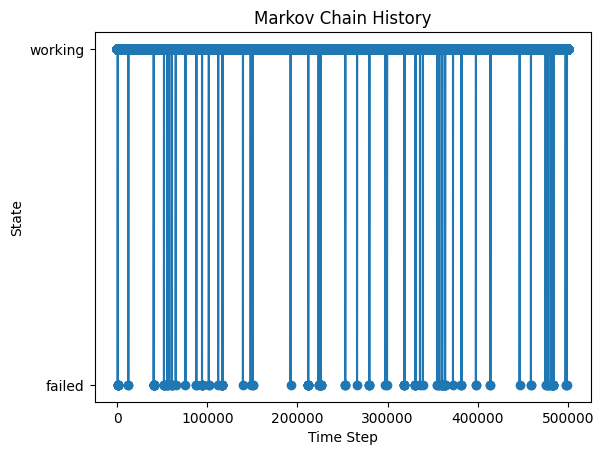

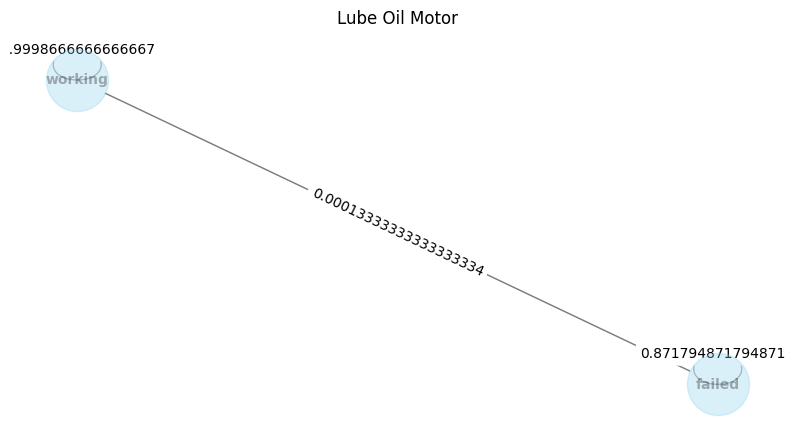

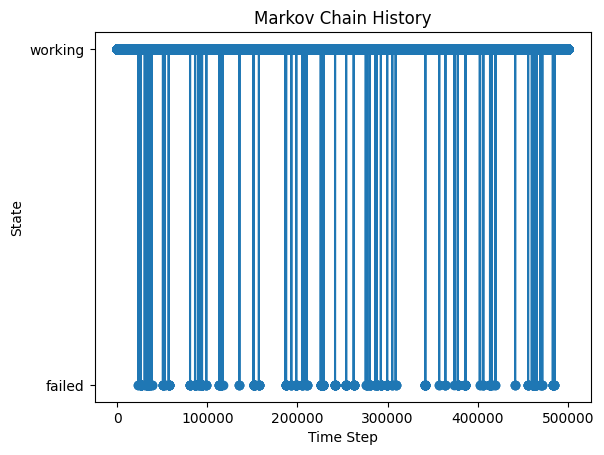

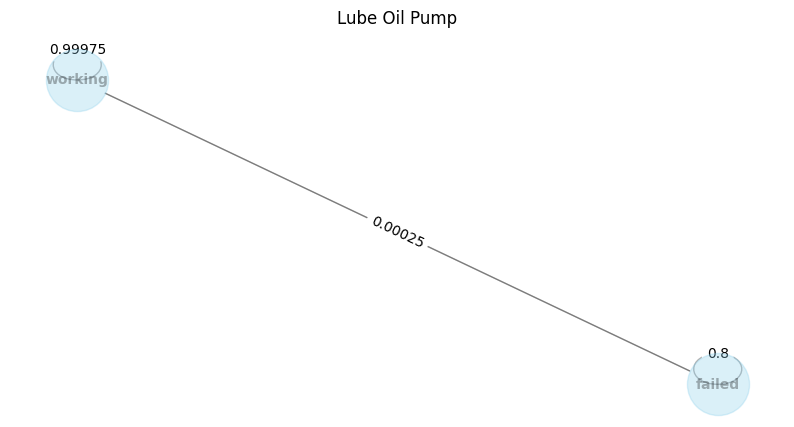

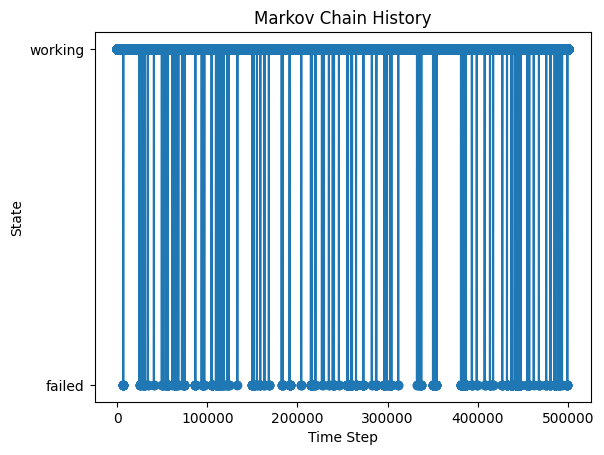

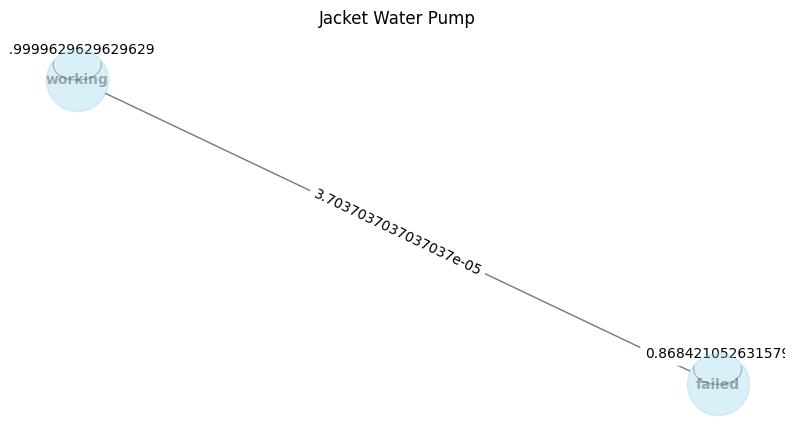

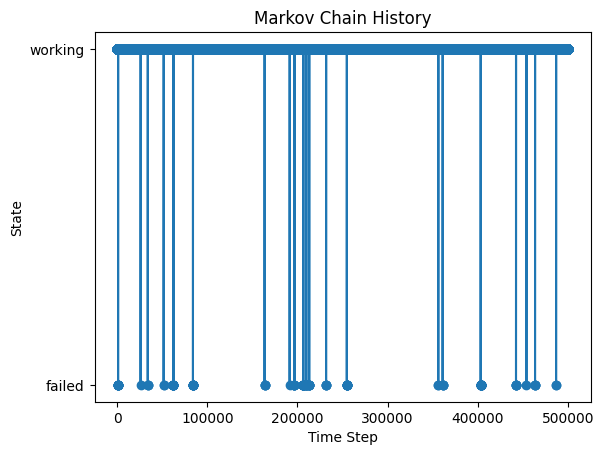

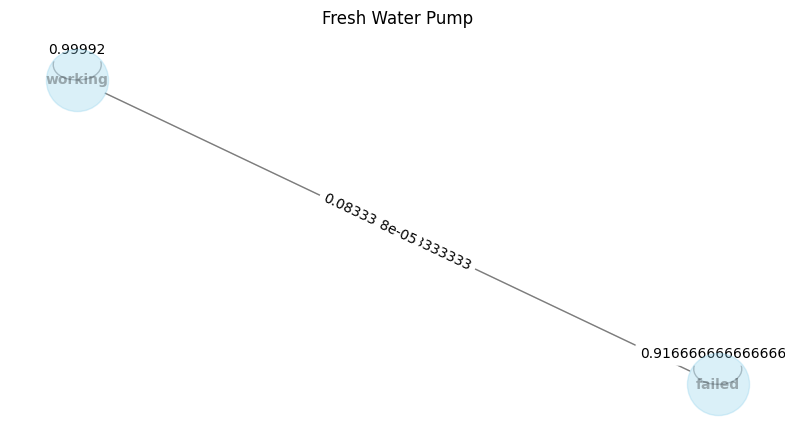

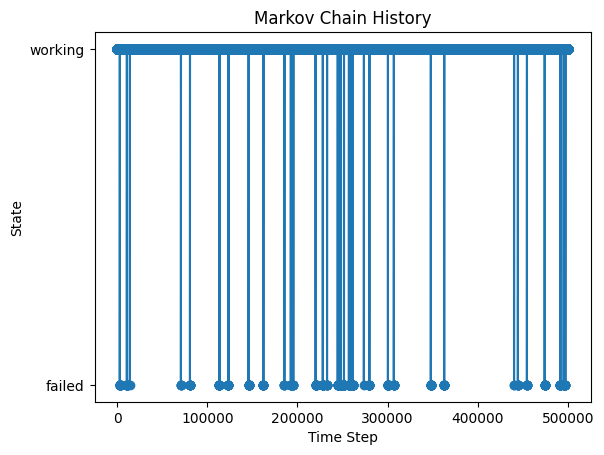

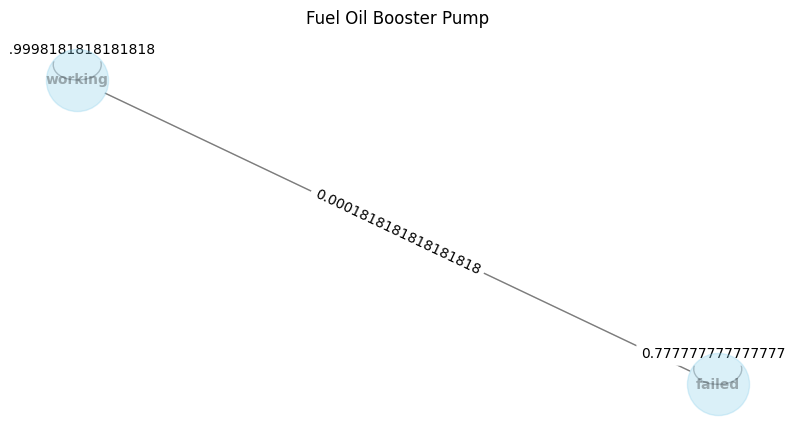

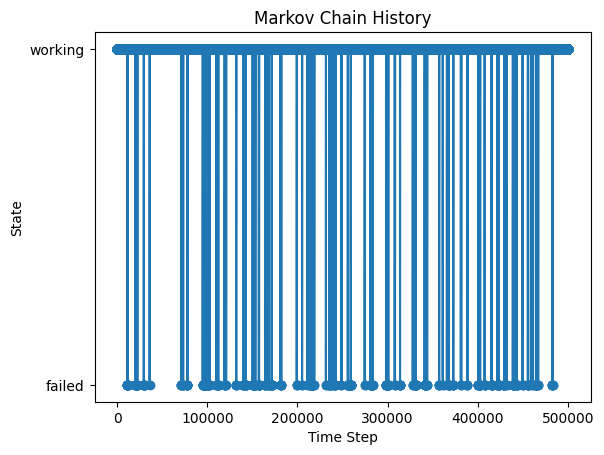

In [6]:
import sys
sys.path.append('..')
from shipClass.MarkovChain import MarkovChain

#fix states for each component 
states = {0: 'failed', 
          1: 'working'}

# simulate the comp markov chain and draw the history as a plot
for comp in data.Component:
    comp_MC = MarkovChain(states, transition_matrices[comp])
    comp_MC.drawChain(comp)
    comp_MC.simulate(500000)          # extra long example
    # comp_MC.simulate(720)               # 720HRs (30 days)
    comp_MC.plotHistory()


## Calculating Important Metric from the Simulations

Number of Repairs

In [7]:
#number of repairs per component
comp_repairs_count = {}

# loop through each component and count the number of repairs
for comp in data.Component:
    repairs = 0

    # repair is an improvement in state (from 0 to 1)
    for i,state in len(comp.history):
        if state[i+1] > state:
            repairs+=1

    comp_repairs_count[comp] = repairs

print(comp_repairs_count)



AttributeError: 'str' object has no attribute 'history'